# introduction and loading data

In [1]:
# following
# using the data from
# https://www.gw-openscience.org/tutorial06/
# but I think their implementation of the
# matched filter is either wrong / simplified
# so instead we compare the scrinet matched_filter
# with the pycbc matched filter

To get started, read in the data and template files, which can both be downloaded using the links in the yellow box above. Both the data and the template have a sampling rate of 4096 Hz. The data is 16 seconds of simulated, colored noise with a signal added somewhere in the first 12 seconds. The template is a 1 second inspiral-like signal. The template has been tapered at the beginning and end, so that it can be more easliy Fourier transformed.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
import numpy as np
import scipy.signal as sig
import h5py

In [3]:
import tensorflow as tf

In [4]:
# Read the data file (16 seconds, sampled at 4096 Hz)

In [5]:
with h5py.File('data_w_signal.hdf5', 'r') as f:
    data = f['strain/Strain'][:]
fs = 4096
dt = 1./fs
time = np.arange(0, 16, dt)

In [6]:
print("shapes:")
print(f"data.shape: {data.shape}")
print(f"time.shape: {time.shape}")

shapes:
data.shape: (65536,)
time.shape: (65536,)


Text(0.5, 1.0, 'strain data')

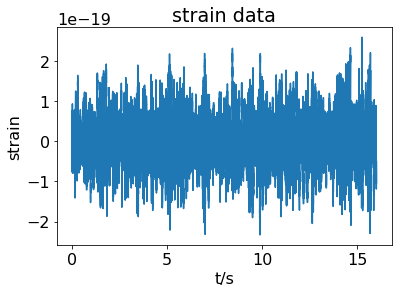

In [7]:
plt.figure()
plt.plot(time, data)
plt.xlabel('t/s')
plt.ylabel('strain')
plt.title('strain data')

In [8]:
# Read the template file (1 second, sampled at 4096 Hz)
with h5py.File('template.hdf5', 'r') as f:
    template = f['strain/Strain'][:]

In [9]:
temp_time = np.arange(0, 1, dt)

In [10]:
print("shapes:")
print(f"template.shape: {template.shape}")
print(f"temp_time.shape: {temp_time.shape}")

shapes:
template.shape: (4096,)
temp_time.shape: (4096,)


Text(0.5, 1.0, 'template')

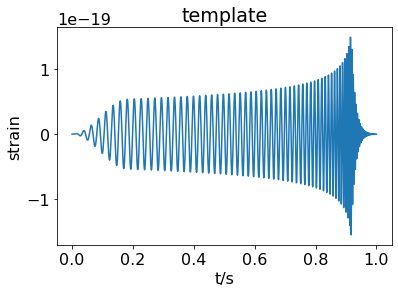

In [11]:
plt.figure()
plt.plot(temp_time, template)
plt.xlabel('t/s')
plt.ylabel('strain')
plt.title('template')

Text(0.5, 1.0, 'strain data and template\n')

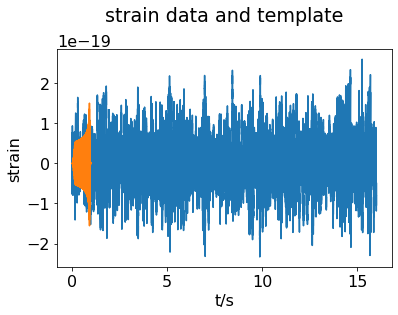

In [12]:
plt.figure()
plt.plot(time, data)
plt.plot(temp_time, template)
plt.xlabel('t/s')
plt.ylabel('strain')
plt.title('strain data and template\n')

# find signal

## matched filter

### using their method

In [13]:
data_fft = np.fft.fft(data)

For this to work, we need the template and the data to be the same length. So, we'll zero-pad the template before we take the FFT:

In [14]:
zero_pad = np.zeros(data.size - template.size)
template_padded = np.append(template, zero_pad)
template_fft = np.fft.fft(template_padded)

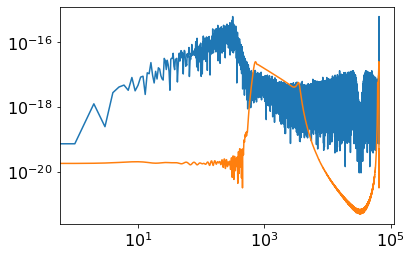

In [15]:
plt.figure()
plt.plot(np.abs(data_fft))
plt.plot(np.abs(template_fft))
plt.yscale('log')
plt.xscale('log')

Next, we need an estimate of the noise power in each FFT bin. We'll take a PSD of the last 4 seconds of data, where we'll assume there's no signal. The numpy FFT function returns an array with a particular convention for the order of the frequency bins, so we'll need to interpolate the PSD to estimate values at each FFT frequency.

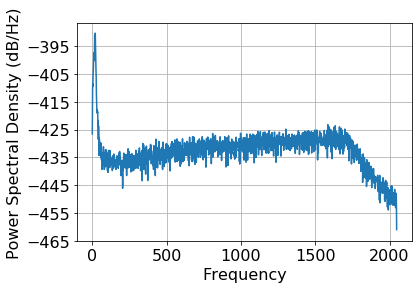

In [16]:
# -- Calculate the PSD of the data
power_data, freq_psd = plt.psd(data[12*fs:], Fs=fs, NFFT=fs)

# -- Interpolate to get the PSD values at the needed frequencies
datafreq = np.fft.fftfreq(data.size)*fs
power_vec = np.interp(datafreq, freq_psd, power_data)

Finally, we can multiply the Fourier Space template and data, and divide by the noise power in each frequency bin. Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain, so the result will be plotted as a function of time off-set between the template and the data:

In [17]:
# -- Calculate the matched filter output
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)

Text(0.5, 0, 't/S')

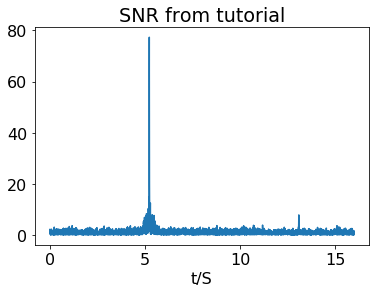

In [18]:
# -- Normalize the matched filter output
df = np.abs(datafreq[1] - datafreq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

# -- Plot the result
plt.figure()
plt.plot(time, SNR)
plt.title("SNR from tutorial")
plt.xlabel("t/S")

### using scrinet methods

In [19]:
from scrinet.analysis.timeseries import TimeSeries
from scrinet.analysis.frequencyseries import FrequencySeries
from scrinet.analysis import matchedfilter

In [20]:
ts_data = TimeSeries(data, delta_t=dt)

In [21]:
ts_template = TimeSeries(template_padded, delta_t=dt)

Text(0, 0.5, 'strain')

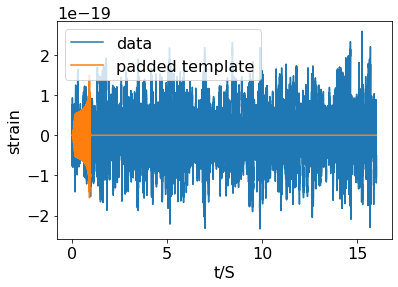

In [22]:
plt.figure()
plt.plot(ts_data.sample_times, ts_data.data, label='data')
plt.plot(ts_template.sample_times, ts_template.data, label='padded template')
plt.legend()
plt.xlabel('t/S')
plt.ylabel('strain')

In [23]:
fs_data = ts_data.to_frequencyseries()

In [24]:
fs_template = ts_template.to_frequencyseries()

In [25]:
fs_data.data.shape

TensorShape([32769])

Text(0.5, 0, 'f/Hz')

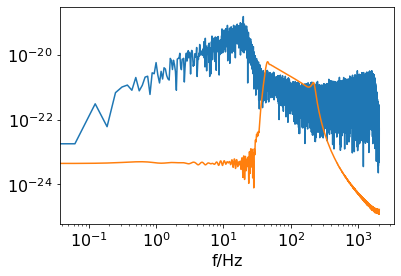

In [26]:
plt.figure()
plt.plot(fs_data.sample_frequencies, np.abs(fs_data.data))
plt.plot(fs_template.sample_frequencies, np.abs(fs_template.data))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("f/Hz")

In [27]:
power_vec.dtype

dtype('float64')

In [28]:
power_vec.shape

(65536,)

In [29]:
fs_psd = FrequencySeries(power_vec, delta_f=df, dtype=tf.complex128)
# fs_psd = FrequencySeries(np.sqrt(power_vec), delta_f=df)

Text(0.5, 0, 'f/Hz')

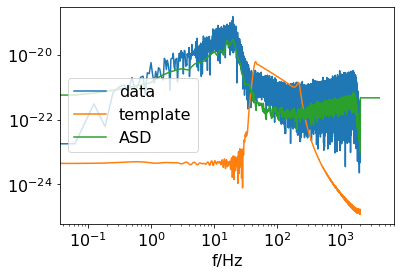

In [30]:
plt.figure()
plt.plot(fs_data.sample_frequencies, np.abs(fs_data.data), label='data')
plt.plot(fs_template.sample_frequencies, np.abs(fs_template.data), label='template')
plt.plot(fs_psd.sample_frequencies, np.sqrt(np.abs(fs_psd.data)), label='ASD')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel("f/Hz")

In [31]:
fs_data.data

<tf.Tensor: shape=(32769,), dtype=complex128, numpy=
array([ 5.01078054e-23+0.00000000e+00j, -1.53182142e-23-8.96653734e-24j,
        3.29217876e-23+3.03984268e-22j, ...,
       -6.20970059e-24-1.51534762e-23j,  1.30303273e-22+5.30458911e-23j,
       -5.18410031e-23+0.00000000e+00j])>

In [32]:
fs_psd.data

<tf.Tensor: shape=(65536,), dtype=complex128, numpy=
array([2.19442396e-43+0.j, 3.26036528e-43+0.j, 4.32630660e-43+0.j, ...,
       2.19442396e-43+0.j, 2.19442396e-43+0.j, 2.19442396e-43+0.j])>

In [33]:
scrinet_snr = matchedfilter.matched_filter(fs_template, fs_data, psd=fs_psd, low_frequency_cutoff=None,
                  high_frequency_cutoff=None)

In [34]:
type(scrinet_snr)

scrinet.analysis.timeseries.TimeSeries

Text(0.5, 0, 't/S')

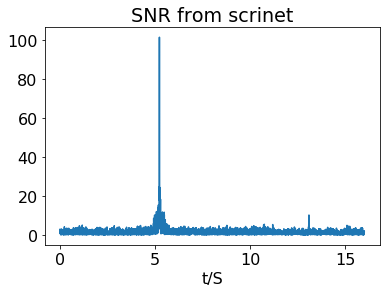

In [35]:
plt.figure()
plt.plot(scrinet_snr.sample_times, np.abs(scrinet_snr.data))
plt.title("SNR from scrinet")
plt.xlabel("t/S")

### using pycbc

In [36]:
import pycbc.filter
import pycbc.types

In [37]:
pycbc_template = pycbc.types.FrequencySeries(fs_template.data.numpy(), delta_f=fs_template.delta_f.numpy())
pycbc_data = pycbc.types.FrequencySeries(fs_data.data.numpy(), delta_f=fs_data.delta_f.numpy())
pycbc_psd = pycbc.types.FrequencySeries(np.abs(fs_psd.data.numpy()), delta_f=fs_psd.delta_f.numpy())

In [38]:
pycbc_snr =  pycbc.filter.matched_filter(pycbc_template, pycbc_data, psd=pycbc_psd, low_frequency_cutoff=None,
                  high_frequency_cutoff=None)

Text(0.5, 0, 't/S')

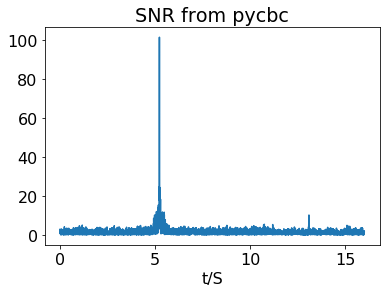

In [39]:
plt.figure()
plt.plot(pycbc_snr.sample_times, np.abs(pycbc_snr.data))
plt.title("SNR from pycbc")
plt.xlabel("t/S")

### comparison

In [40]:
peak_idx = np.argmax(np.abs(scrinet_snr.data.numpy()))
peak_time = scrinet_snr.sample_times.numpy()[peak_idx]
print(f"peak time: {peak_time} s")

peak time: 5.23046875 s


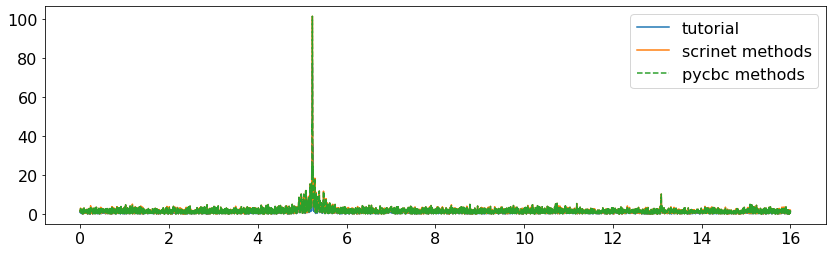

In [41]:
plt.figure(figsize=(14,4))
plt.plot(time, SNR, label='tutorial')
plt.plot(scrinet_snr.sample_times, np.abs(scrinet_snr.data), label='scrinet methods', ls='-')
plt.plot(pycbc_snr.sample_times, np.abs(pycbc_snr.data), label='pycbc methods', ls='--')
plt.legend()

(5.13046875, 5.33046875)

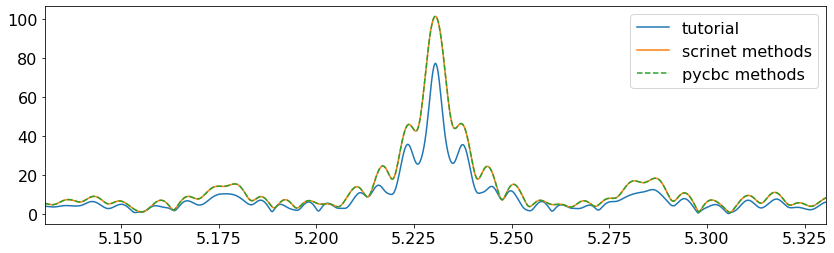

In [42]:
plt.figure(figsize=(14,4))
plt.plot(time, SNR, label='tutorial')
plt.plot(scrinet_snr.sample_times, np.abs(scrinet_snr.data), label='scrinet methods', ls='-')
plt.plot(pycbc_snr.sample_times, np.abs(pycbc_snr.data), label='pycbc methods', ls='--')
plt.legend()
plt.xlim(peak_time-0.1, peak_time+0.1)

In [43]:
pycbc_snr_array = np.abs(pycbc_snr.data)
scrinet_snr_array = np.abs(scrinet_snr.data)
tutorial_snr_array = np.abs(SNR)

Text(0.5, 0, 't/S')

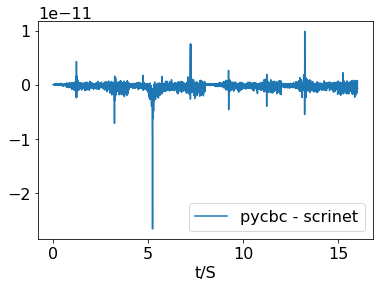

In [44]:
plt.figure()
plt.plot(time, pycbc_snr_array - scrinet_snr_array, label='pycbc - scrinet')
plt.legend()
plt.xlabel('t/S')

Text(0.5, 0, 't/S')

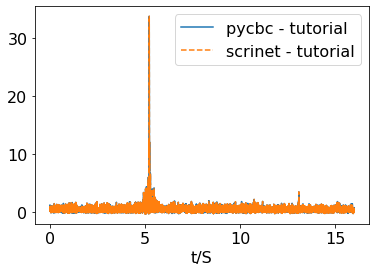

In [45]:
plt.figure()
plt.plot(time, pycbc_snr_array - tutorial_snr_array, label='pycbc - tutorial')
plt.plot(time, scrinet_snr_array - tutorial_snr_array, label='scrinet - tutorial', ls='--')
plt.legend()
plt.xlabel('t/S')